# Analysis of different datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [2]:
# function to clean content field
def clean_content(text):

    # regular expression for dates
    def re_date():
        re_numdate = r'(?:\d{1,4}(?:\/\d{1,2}\/|-\d{1,2}-)\d{1,4})'
        re_day = r'(?:\d{1,2}(?:th|st|nd|rd|\.)?)'
        re_month = r'(?:jan(?:uary|\.)?|feb(?:ruary|\.)?|mar(?:ch|\.)?|apr(?:il|\.)?|may\.?|jun(?:e|\.)?' \
                   r'|jul(?:y|\.)?|aug(?:ust|\.)?|sept?(?:ember|\.)?|oct(?:ober|\.)?|nov(?:ember|\.)?' \
                   r'|dec(?:ember|\.)?)'
        re_year = r'(?:[, ]*\d{4})?'
        reg = r'(' + re_numdate + \
              r'|(?:' + re_month + r'[, ]*' + re_day + re_year + r')' \
              r'|(?:(?:the)? ?' + re_day + r' (?:of)? ?' + re_month + re_year + r'))'   
        return re.compile(reg)
    
    if pd.notnull(text):
        re_whitespace = re.compile(r"(\s+)")
        re_urls = re.compile(r"(?<=\s)((?:https?://)?\w+(?:\.?\w)*\.(?:com|org|net|dk)(?:\/[\w/?.#=\-+%]*)?)")
        re_email = re.compile(r"(?<=\s)(\w(?:\.?[\w+\-])*@\w(?:[.\-]?\w)*)")
        re_date = re_date()
        re_num = re.compile(r"(\d+(?:,\d{3})*(?:\.\d+)?)")

        text = re_whitespace.sub(' ',text)
        text = text.lower()
        text = re_urls.sub('<URL>',text)
        text = re_email.sub('<EMAIL>',text)
        text = re_date.sub('<DATE>',text)
        text = re_num.sub('<NUM>',text)

        return text
    else:
        return None

## Loading Fake News Corpus dataset

In [3]:
# load and clean data 
filepath = '~/fake_news/1mio-clean.csv'
df = pd.read_csv(filepath,usecols=[3,5])
df = df.dropna()
df = df.drop_duplicates()
# convert to binary types
df['b_type'] = df['type'].apply(lambda x: 1 if x in ['fake','satire','bias',
                                                     'conspiracy','junksci'] else 0)
df = df.drop(df[df['content'].str.match('[а-яА-Я]')].index) #removing russian articles
df['set'] = 'FAKE NEWS'
print('number of rows:',len(df))

number of rows: 583182


In [ ]:
# split into train and test
train, test = train_test_split(df, test_size=0.2, random_state=1)

## Loading LIAR set

In [5]:
# load liar dataset
l1 = pd.read_csv('liar_dataset/train.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
l2 = pd.read_csv('liar_dataset/test.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
l3 = pd.read_csv('liar_dataset/valid.tsv',usecols=[1,2],sep='\t',header=None,names=['label','content'])
liar = pd.concat([l1,l2,l3])
# clean
liar = liar.dropna()
liar['content'] = liar['content'].apply(clean_content)

liar['set'] = 'LIAR'

## Loading Kaggle set

In [6]:
# load kaggle test set
kaggle = pd.read_json('test_set.json')

kaggle['content'] = kaggle['article']
kaggle['set'] = 'KAGGLE'

# clean
kaggle['content'] = kaggle['content'].apply(clean_content)

## Plotting differences in length and word count

In [7]:
#union of dataframes
frames = [test[['content','set']],liar[['content','set']],kaggle[['content','set']]]
df_a = pd.concat(frames,sort=True)

In [8]:
# potential features
df_a['length'] = df_a.content.apply(len)
df_a['word_count'] = df_a.content.apply(lambda x: len(str(x).split()))

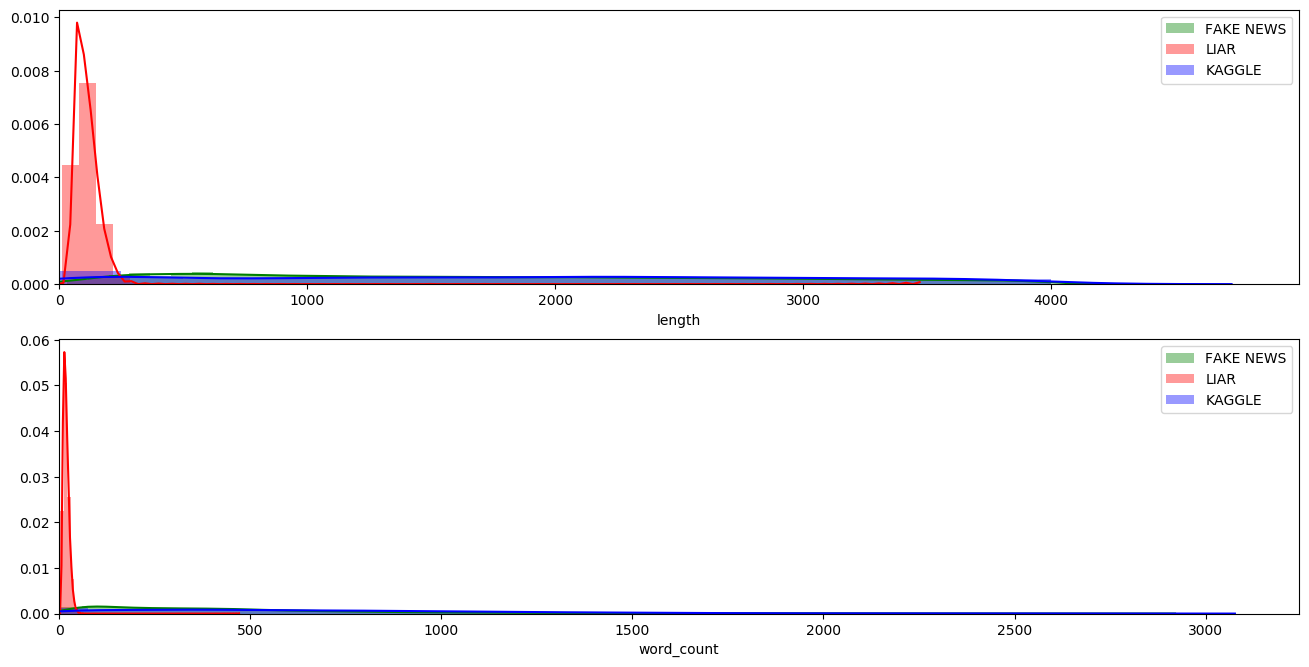

In [9]:
thresholds = [4000, 2800]
features = ['length','word_count']
fig, axes = plt.subplots(nrows=len(features), figsize=(16,4*len(features)), dpi=100)
for i,f in enumerate(features):
    try: sns.distplot(df_a.loc[(df_a['set']=='FAKE NEWS') & (df_a[f] < thresholds[i])][f], label='FAKE NEWS', color='green', ax=axes[i]) 
    except: pass
    try: sns.distplot(df_a.loc[(df_a['set']=='LIAR') & (df_a[f] < thresholds[i])][f], label='LIAR', color='red', ax=axes[i]) 
    except: pass
    try: sns.distplot(df_a.loc[(df_a['set']=='KAGGLE') & (df_a[f] < thresholds[i])][f], label='KAGGLE', color='blue', ax=axes[i]) 
    except: pass
for ax in axes:
    ax.legend()
    ax.set_xlim(0)

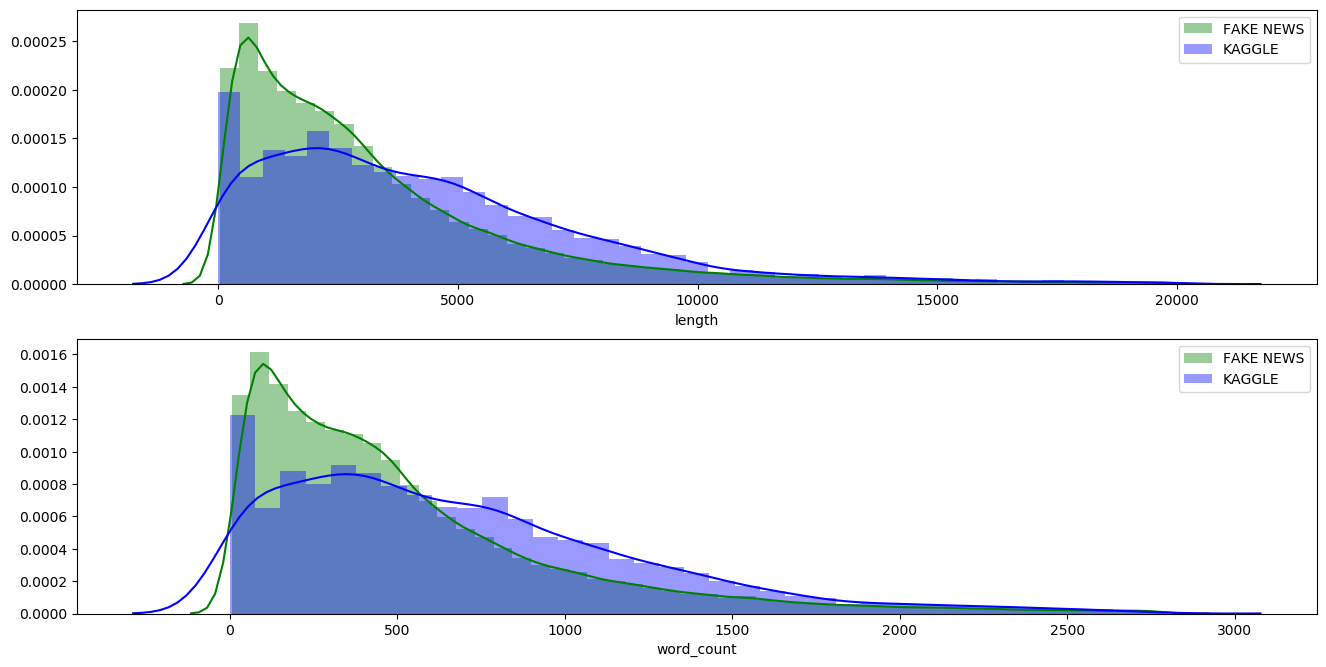

In [10]:
thresholds = [20000, 2800]
features = ['length','word_count']
fig, axes = plt.subplots(nrows=len(features), figsize=(16,4*len(features)), dpi=100)
for i,f in enumerate(features):
    try: sns.distplot(df_a.loc[(df_a['set']=='FAKE NEWS') & (df_a[f] < thresholds[i])][f], label='FAKE NEWS', color='green', ax=axes[i]) 
    except: pass
    try: sns.distplot(df_a.loc[(df_a['set']=='KAGGLE') & (df_a[f] < thresholds[i])][f], label='KAGGLE', color='blue', ax=axes[i]) 
    except: pass
for ax in axes:
    ax.legend()

## Most important features used by the model

#### Training the model

In [11]:
# determine tf-idf
x_train, x_test, y_train, y_test = train.content, test.content, train.b_type, test.b_type
vectorizer = TfidfVectorizer()
x_train_v = vectorizer.fit_transform(x_train)
x_test_v = vectorizer.transform(x_test)

In [12]:
# train model, predict
model = LinearSVC(random_state=1)
model = model.fit(x_train_v, y_train)

In [16]:
# score
print('accuracy:',model.score(x_test_v,y_test))

accuracy: 0.8803724375626946


#### Most important features

In [17]:
# most important features which the model uses
def most_important_features(n):
    feature_names = vectorizer.get_feature_names()
    sorted_coef = sorted(zip(model.coef_[0], feature_names))
    real = sorted(sorted_coef[:n], reverse=True)
    fake = sorted_coef[-n:]
    return real, fake
important = most_important_features(10)

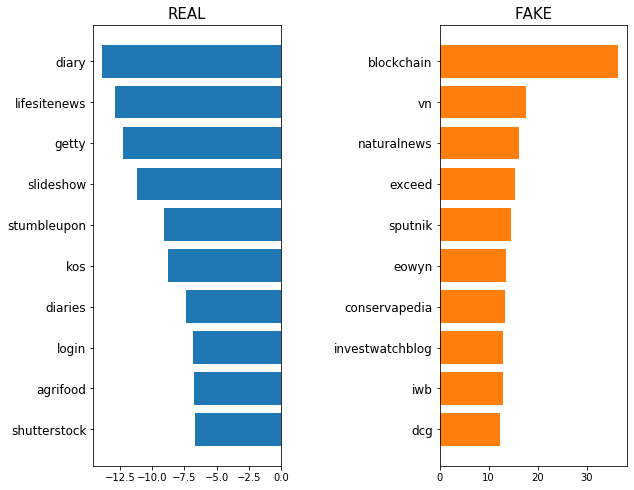

In [18]:
#plot most important features
fig, axes = plt.subplots(ncols=2, figsize=(10,8))
for i,elm in enumerate(important):
    y,x = zip(*elm)
    axes[i].barh(x, y, color=['C0','C1'][i])
    axes[i].set_title(['REAL','FAKE'][i], fontsize=15)
    axes[i].set_yticklabels(x, fontsize=12)

fig.tight_layout(pad=5)

## Comparision of datasets

#### Count number of occurences of each important word

In [19]:
important_words = list(zip(*important[0]))[1] + list(zip(*important[1]))[1]
d = {'Test':[],'Kaggle':[],'Liar':[]}

# counting the number of occurences for each set
for word in important_words:
    n_test = 0
    n_kaggle = 0
    n_liar = 0

    for text in x_test:
        n_test += text.count(word)
    for text in kaggle.article:
        n_kaggle += text.count(word)
    for text in liar.content:
        n_liar += text.count(word)
        
    d['Test'] += [n_test/len(x_test)]
    d['Kaggle'] += [n_kaggle/len(kaggle)]
    d['Liar'] += [n_liar/len(liar)]

In [20]:
# DataFrame of the result
d = pd.DataFrame(d, index=important_words)
d

,Test,Kaggle,Liar
shutterstock,0.001886,0.000316,0.000000
agrifood,0.000000,0.000000,0.000000
login,0.004030,0.001105,0.000000
diaries,0.020765,0.001579,0.000000
kos,0.083764,0.008051,0.000625
stumbleupon,0.007613,0.000000,0.000000
slideshow,0.030736,0.000000,0.000000
getty,0.091763,0.000000,0.000078
lifesitenews,0.008411,0.000000,0.000000
diary,0.062502,0.009945,0.000078


Plot of the normalized number of occurences for each test set: Test set of Fake News Corpus, the Kaggle set and the LIAR set:

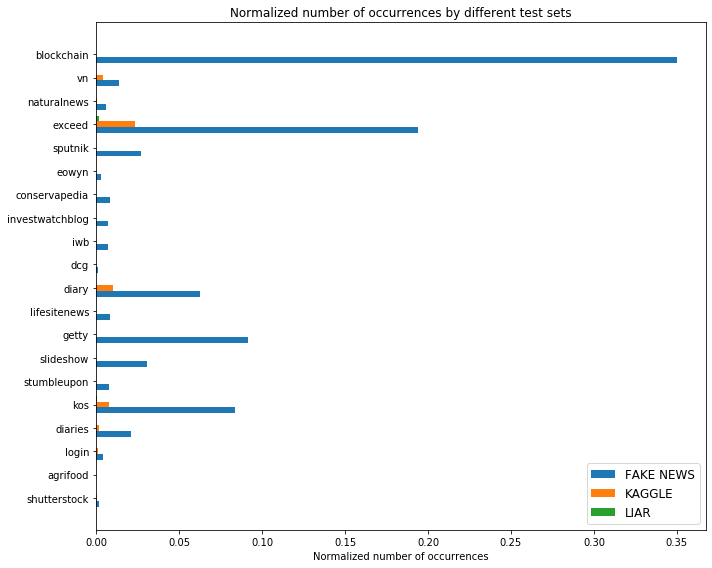

In [21]:
y = np.arange(len(d))*2  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

# bar plot of each group
ax.barh(y - width, d['Test'], width, label='FAKE NEWS')
ax.barh(y, d['Kaggle'], width, label='KAGGLE')
ax.barh(y + width, d['Liar'], width, label='LIAR')

ax.set_xlabel('Normalized number of occurrences')
ax.set_title('Normalized number of occurrences by different test sets')
ax.set_yticks(y)
ax.set_yticklabels(d.index)
ax.legend(loc='lower right', fontsize=12)

fig.tight_layout()
plt.savefig('5_occur_1')
plt.show()

The plot is made again, where the limit on the x-axis is changed to 0.05, so it is easier to see the small values:

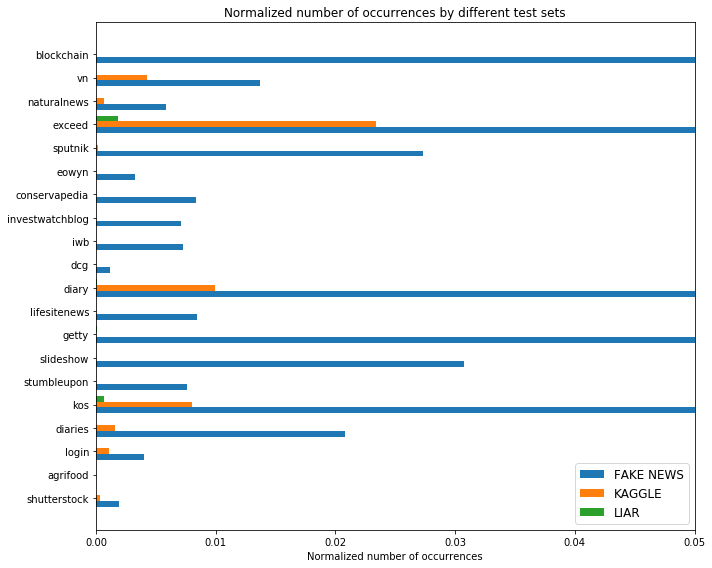

In [22]:
y = np.arange(len(d))*2  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

# bar plot of each group
ax.barh(y - width, d['Test'], width, label='FAKE NEWS')
ax.barh(y, d['Kaggle'], width, label='KAGGLE')
ax.barh(y + width, d['Liar'], width, label='LIAR')

ax.set_xlabel('Normalized number of occurrences')
ax.set_title('Normalized number of occurrences by different test sets')
ax.set_yticks(y)
ax.set_yticklabels(d.index)
ax.legend(loc='lower right', fontsize=12)

ax.set_xlim(0,0.05) # limit on x-axis

fig.tight_layout()

plt.savefig('5_occur_2')
plt.show()